In [1]:
import os
import generate_features
import polars as pl

df = pl.read_csv("./combined.csv")

from sklearn.preprocessing import StandardScaler

print(df)
scaler = StandardScaler()
name_df = df.clone()
df.write_csv("./features_all.csv")
df = df.select(
    pl.exclude("name")
)
df = pl.DataFrame(scaler.fit_transform(df))
data = df.to_numpy()
print(df)
print(df.std())
print(df.mean())

# weight
# df = df.with_columns(
#     column_74 = pl.col("column_74") * 3,
#     column_75 = pl.col("column_75") * 3,
# )

print(df)
print(df.std())
print(df.mean())


shape: (136, 77)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ name      ┆ ankle_lef ┆ ankle_rig ┆ pelvis_av ┆ … ┆ pelvis_ma ┆ solar_ple ┆ wrist_lef ┆ wrist_ri │
│ ---       ┆ t_avg_hei ┆ ht_avg_he ┆ g_height  ┆   ┆ x_acceler ┆ xus_max_a ┆ t_max_acc ┆ ght_max_ │
│ str       ┆ ght       ┆ ight      ┆ ---       ┆   ┆ ation     ┆ ccelerati ┆ eleration ┆ accelera │
│           ┆ ---       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ on        ┆ ---       ┆ tion     │
│           ┆ f64       ┆ f64       ┆           ┆   ┆ f64       ┆ ---       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ dance_dat ┆ -0.911603 ┆ -0.907652 ┆ -0.016845 ┆ … ┆ 0.307488  ┆ 0.282413  ┆ 0.345603  ┆ 0.768571 │
│ a_0_corre ┆           ┆           ┆           ┆   ┆           ┆         

(136, 76)


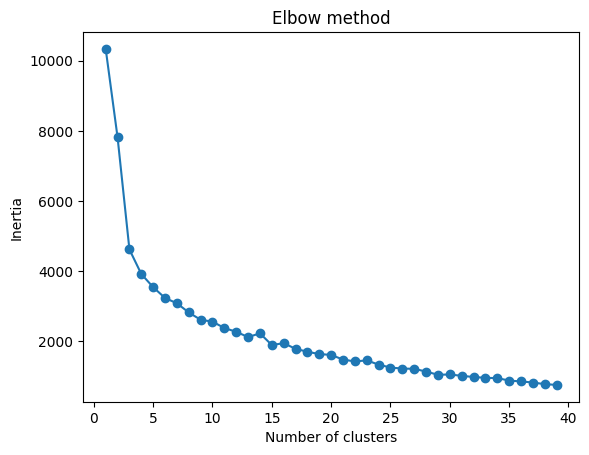

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print(data.shape)
inertias = []
for i in range(1,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

import matplotlib.pyplot as plt

plt.plot(range(1,40), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [2]:
from sklearn.cluster import KMeans

print(data.shape)
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)
clusters = kmeans.predict(data)
print(clusters)

cluster_dict = {"cluster": clusters}
cluster_df = pl.from_dict(cluster_dict)

df = df.hstack(cluster_df)
print(df)


(136, 76)
[0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 2 3 2 3 3 0 3 3 0 0 2 3 2 3 2 2 0 3
 0 0 0 0 0 0 0 0 3 0 3 0 0 3 3 3 0 3 0 0 0 0 0 2 2 3 2 0 1 3 3 3 3 0 2 3 0
 0 2 3 3 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 3 3 3 0 3 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 3 2 3 3 2 0 3 0 0 2 2 3 2 0 0 0]
shape: (136, 77)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬─────────┐
│ column_0  ┆ column_1  ┆ column_2  ┆ column_3 ┆ … ┆ column_73 ┆ column_74 ┆ column_75 ┆ cluster │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---     │
│ f64       ┆ f64       ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i32     │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═════════╡
│ -0.848107 ┆ -0.885804 ┆ -0.086742 ┆ 0.10507  ┆ … ┆ 1.25369   ┆ 1.23572   ┆ 3.410691  ┆ 0       │
│ -0.797031 ┆ -0.821449 ┆ 0.016227  ┆ 0.199076 ┆ … ┆ -0.18147  ┆ -0.253139 ┆ -0.308949 ┆ 0       │
│ -

ValueError: too many values to unpack (expected 2)

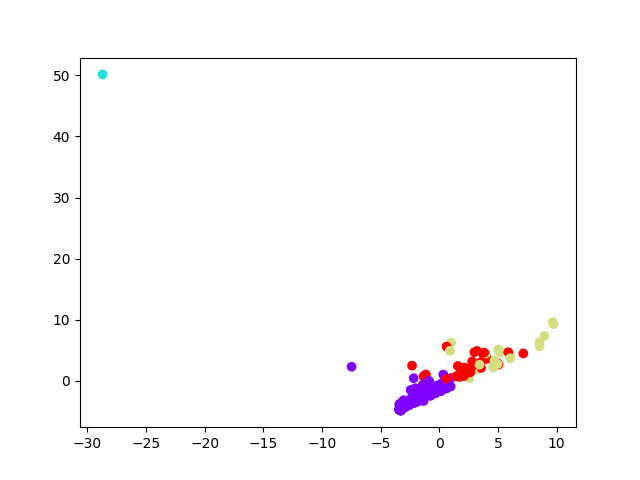

In [3]:
from sklearn.decomposition import PCA
%matplotlib widget
import matplotlib.pyplot as plt

n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data) 
data = df.with_columns(
    pl.exclude("cluster")
    ).to_numpy()

clusters = df["cluster"]
names = name_df["name"].to_list()

# Plot the results
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_pca[:, 1], X_pca[:, 0], c=clusters, cmap=plt.cm.rainbow)
for i, name in enumerate(names):
    ax.annotate((X_pca[i:, 1], X_pca[i:, 0]), name)
plt.title("PCA Visualization")
plt.tight_layout()
plt.show()

In [7]:
named_cluster = name_df.hstack(cluster_df.select(pl.col("cluster")))
named_cluster = named_cluster.select(
    pl.col("name"),
    pl.col("cluster"),
).sort(
    pl.col("cluster")
)

print(named_cluster)
named_cluster.write_csv("./k-means.csv")

shape: (136, 2)
┌──────────────────────────┬─────────┐
│ name                     ┆ cluster │
│ ---                      ┆ ---     │
│ str                      ┆ i32     │
╞══════════════════════════╪═════════╡
│ dance_data_0_corrected   ┆ 0       │
│ dance_data_1_corrected   ┆ 0       │
│ dance_data_100_corrected ┆ 0       │
│ dance_data_101_corrected ┆ 0       │
│ dance_data_102_corrected ┆ 0       │
│ …                        ┆ …       │
│ dance_data_85_corrected  ┆ 3       │
│ dance_data_87_corrected  ┆ 3       │
│ dance_data_88_corrected  ┆ 3       │
│ dance_data_90_corrected  ┆ 3       │
│ dance_data_95_corrected  ┆ 3       │
└──────────────────────────┴─────────┘
